## 환경 설정 및 준비

`(1) Env 환경변수`

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

`(2) 기본 라이브러리`

In [2]:
import os
from glob import glob

from pprint import pprint
import json

### **`Send` 객체의 사용 예시**

- 문서 요약 시스템 (대용량 텍스트 처리)
- 긴 문서를 여러 부분으로 나누어 병렬로 요약한 후 통합하는 시스템

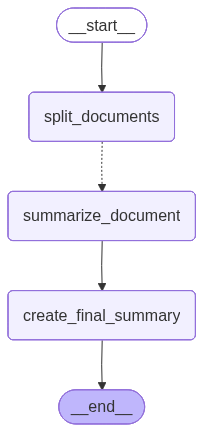

In [3]:
import operator
from typing import Annotated, List, Dict, Tuple, Any
from typing_extensions import TypedDict
from langchain_core.documents import Document
from langgraph.types import Send
from langgraph.graph import END, START, StateGraph
from langchain_openai import ChatOpenAI  
from IPython.display import Image, display

# LLM 모델 초기화
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

class SummarizationState(TypedDict):
    contents: List[Document]  # 초기 Document 객체 리스트
    chunks: List[Dict[str, Any]]  # 청크 리스트 (인덱스, 내용, 메타데이터 포함)
    summaries: Annotated[List[Tuple[int, str]], operator.add]  # (인덱스, 요약) 튜플 리스트
    final_summary: str

class DocumentState(TypedDict):
    content: str
    index: int  # 청크의 순서를 나타내는 인덱스

def split_documents(state: SummarizationState):
    """각 Document를 순서를 유지하며 청크로 분할"""
    chunks = []
    chunk_size = 1000
    global_chunk_index = 0
    
    # 각 Document를 순차적으로 처리
    for doc_index, document in enumerate(state["contents"]):
        content = document.page_content
        
        # 해당 문서를 청크로 분할
        for i in range(0, len(content), chunk_size):
            chunk_content = content[i:i + chunk_size]
            
            # 빈 청크는 스킵
            if chunk_content.strip():
                chunks.append({
                    "index": global_chunk_index,
                    "content": chunk_content,
                    "source_document": doc_index,
                    "source_metadata": document.metadata
                })
                global_chunk_index += 1
    
    return {"chunks": chunks}

def summarize_document(state: DocumentState):
    """개별 문서 청크를 요약"""
    prompt = f"""다음 텍스트를 2-3문장으로 간결하게 요약해주세요:
    
    {state['content']}
    """
    
    try:
        response = model.invoke(prompt)
        summary = response.content
    except Exception as e:
        summary = f"요약 생성 중 오류 발생: {str(e)}"
    
    # 순서 정보와 함께 요약 반환
    return {"summaries": [(state["index"], summary)]}

def continue_to_summarization(state: SummarizationState):
    """각 청크를 병렬로 요약하도록 Send 작업 생성"""
    return [
        Send("summarize_document", {
            "content": chunk["content"],
            "index": chunk["index"]
        }) 
        for chunk in state["chunks"]
    ]

def create_final_summary(state: SummarizationState):
    """순서를 유지하며 최종 요약 생성"""
    # 인덱스별로 요약을 정렬
    sorted_summaries = sorted(state["summaries"], key=lambda x: x[0])
    
    # 순서대로 요약들을 결합
    ordered_summaries = [summary for _, summary in sorted_summaries]
    combined_summaries = "\n\n".join(ordered_summaries)
    
    prompt = f"""다음은 문서를 청크별로 요약한 내용들입니다. 
    이들을 종합하여 하나의 포괄적이고 일관성 있는 최종 요약을 작성해주세요.
    원본 문서의 순서와 흐름을 유지하면서 핵심 내용을 간결하게 정리해주세요:
    
    {combined_summaries}
    
    최종 요약:
    """
    
    try:
        response = model.invoke(prompt)
        final_summary = response.content
    except Exception as e:
        final_summary = f"최종 요약 생성 중 오류 발생: {str(e)}"
    
    return {"final_summary": final_summary}

# 그래프 구성
builder = StateGraph(SummarizationState)
builder.add_node("split_documents", split_documents)
builder.add_node("summarize_document", summarize_document)
builder.add_node("create_final_summary", create_final_summary)

# 엣지 연결
builder.add_edge(START, "split_documents")
builder.add_conditional_edges("split_documents", continue_to_summarization, ["summarize_document"])
builder.add_edge("summarize_document", "create_final_summary")
builder.add_edge("create_final_summary", END)

# 그래프 컴파일
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
# 테스트용 문서 생성 (PDF가 없는 경우를 대비)
# PDF 파일이 있다면 아래 주석을 해제하고 사용하세요:
# from langchain_community.document_loaders import PyPDFLoader
# loader = PyPDFLoader("data/labor_law.pdf")
# documents = loader.load()

# 테스트용 긴 텍스트 문서 생성
from langchain_core.documents import Document

# 긴 텍스트 생성 (여러 청크로 분할될 수 있도록)
test_text = """
LangGraph는 LangChain의 고급 워크플로우 관리 도구입니다. 
이 도구를 사용하면 복잡한 다단계 작업을 효율적으로 구성하고 실행할 수 있습니다.
특히 Send 객체를 활용하면 병렬 처리가 가능하여 대용량 문서 처리에 유용합니다.

LangGraph의 주요 기능 중 하나는 StateGraph입니다.
StateGraph를 통해 상태 기반의 워크플로우를 정의할 수 있으며,
각 노드는 특정 작업을 수행하고 상태를 업데이트합니다.
노드 간의 연결은 엣지로 표현되며, 조건부 엣지를 통해 동적인 워크플로우 구성이 가능합니다.

Send 객체는 특히 강력한 기능입니다.
이를 통해 하나의 노드에서 여러 개의 병렬 작업을 생성할 수 있습니다.
예를 들어, 긴 문서를 여러 청크로 나눈 후 각 청크를 병렬로 처리할 수 있습니다.
이는 처리 시간을 크게 단축시키고 효율성을 높입니다.

문서 요약 작업의 경우, Send를 활용한 병렬 처리가 매우 효과적입니다.
먼저 문서를 적절한 크기의 청크로 분할한 후,
각 청크를 독립적으로 요약하고,
마지막으로 모든 요약을 통합하여 최종 요약을 생성합니다.

이러한 접근 방식은 대용량 문서를 처리할 때 특히 유용합니다.
각 청크가 독립적으로 처리되므로 병렬성이 높고,
결과적으로 전체 처리 시간이 크게 감소합니다.
또한 메모리 사용도 효율적으로 관리할 수 있습니다.

LangGraph는 다양한 체크포인트 기능도 제공합니다.
MemorySaver를 통해 세션 간 상태를 유지할 수 있으며,
InMemoryStore를 활용하면 장기 메모리 구현도 가능합니다.
이러한 기능들을 조합하면 복잡한 대화형 AI 시스템을 구축할 수 있습니다.

실제 프로덕션 환경에서는 다양한 고려사항이 있습니다.
에러 핸들링, 재시도 로직, 타임아웃 관리 등이 중요합니다.
LangGraph는 이러한 요구사항을 충족할 수 있는 유연성을 제공합니다.
개발자는 자신의 요구에 맞게 워크플로우를 커스터마이징할 수 있습니다.

결론적으로 LangGraph는 현대적인 LLM 애플리케이션 개발에 필수적인 도구입니다.
복잡한 워크플로우를 간단하게 관리하고,
병렬 처리를 통해 성능을 최적화하며,
상태 관리를 통해 안정적인 시스템을 구축할 수 있습니다.
"""

# 여러 페이지를 시뮬레이션하기 위해 3개의 Document 생성
documents = [
    Document(
        page_content=test_text,
        metadata={"page": 1, "source": "test_document_1"}
    ),
    Document(
        page_content=test_text + "\n\n추가 내용: 이 문서는 테스트를 위한 두 번째 페이지입니다.",
        metadata={"page": 2, "source": "test_document_2"}
    ),
    Document(
        page_content="마지막 페이지의 내용입니다. LangGraph를 활용하면 효율적인 문서 처리 시스템을 구축할 수 있습니다.",
        metadata={"page": 3, "source": "test_document_3"}
    )
]

print(f"로드된 페이지 수: {len(documents)}")
print(f"첫 번째 문서 길이: {len(documents[0].page_content)} 문자")

로드된 페이지 수: 3
첫 번째 문서 길이: 1096 문자


In [5]:
# PDF 문서 요약 실행
initial_state = {
    "contents": documents,
}
    
for step in graph.stream(initial_state, stream_mode="values"):
    if "chunks" in step:
        print(f"처리 중인 청크 수: {len(step['chunks'])}")
    if "summaries" in step:
        print(f"현재까지 생성된 요약 수: {len(step['summaries'])}")
    if "final_summary" in step:
        print("최종 요약 생성 중...")
        print(step["final_summary"])  # 최종 요약 출력
    print("-"*100)

현재까지 생성된 요약 수: 0
----------------------------------------------------------------------------------------------------
처리 중인 청크 수: 5
현재까지 생성된 요약 수: 0
----------------------------------------------------------------------------------------------------
처리 중인 청크 수: 5
현재까지 생성된 요약 수: 5
----------------------------------------------------------------------------------------------------
처리 중인 청크 수: 5
현재까지 생성된 요약 수: 5
최종 요약 생성 중...
LangGraph는 LangChain의 고급 워크플로우 관리 도구로, 복잡한 다단계 작업을 효율적으로 구성하고 실행할 수 있도록 지원합니다. 이 도구는 Send 객체를 활용한 병렬 처리 기능을 통해 대용량 문서 처리를 용이하게 하며, StateGraph를 통해 상태 기반의 동적인 워크플로우를 정의할 수 있습니다. 또한, 다양한 체크포인트 기능과 유연한 커스터마이징 옵션을 제공하여 복잡한 대화형 AI 시스템 구축에 적합합니다. LangGraph는 복잡한 워크플로우를 간단하게 관리하고 성능을 최적화하며 안정적인 시스템을 구축하는 데 필수적인 도구입니다. 이를 통해 효율적인 문서 처리 시스템을 구축할 수 있습니다.
----------------------------------------------------------------------------------------------------


In [6]:
# 최종 상태 출려
print("최종 상태:")
print("최종 요약:", step.get("final_summary", "요약이 생성되지 않았습니다."))
print("전체 청크 수:", len(step.get("chunks", [])))
print("전체 요약 수:", len(step.get("summaries", [])))
print("전체 문서 수:", len(step.get("contents", [])))

최종 상태:
최종 요약: LangGraph는 LangChain의 고급 워크플로우 관리 도구로, 복잡한 다단계 작업을 효율적으로 구성하고 실행할 수 있도록 지원합니다. 이 도구는 Send 객체를 활용한 병렬 처리 기능을 통해 대용량 문서 처리를 용이하게 하며, StateGraph를 통해 상태 기반의 동적인 워크플로우를 정의할 수 있습니다. 또한, 다양한 체크포인트 기능과 유연한 커스터마이징 옵션을 제공하여 복잡한 대화형 AI 시스템 구축에 적합합니다. LangGraph는 복잡한 워크플로우를 간단하게 관리하고 성능을 최적화하며 안정적인 시스템을 구축하는 데 필수적인 도구입니다. 이를 통해 효율적인 문서 처리 시스템을 구축할 수 있습니다.
전체 청크 수: 5
전체 요약 수: 5
전체 문서 수: 3
